In [1]:
import tensorflow as tf
import time
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
print(tf.__version__)
print(matplotlib.__version__)
print(np.__version__)

2.1.0
3.0.3
1.18.2


In [2]:
#hyperparameters
latent_dim = 100
lr = 1e-3
epochs = 1000
batch_size = 256
dropout_rate = 0.2
seed = 500
save_interval = 50 

In [3]:
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.Dense_1 = tf.keras.layers.Dense(128)
        self.Dense_2 = tf.keras.layers.Dense(28*28, activation='sigmoid')
        
        self.reshape = tf.keras.layers.Reshape((28,28,1))
    
    def call(self, inputs):
        x = self.Dense_1(inputs)
        x = tf.keras.layers.LeakyReLU()(x)
        x = self.Dense_2(x)
        x = self.reshape(x)
        return x

In [5]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        
        self.Dense_1 = tf.keras.layers.Dense(128)

        self.Dense_2 = tf.keras.layers.Dense(1, activation='sigmoid')
    
        self.dropout_1 = tf.keras.layers.Dropout(dropout_rate)

    
    def call(self, inputs):
        x = self.flatten(inputs)
        x = self.Dense_1(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = self.dropout_1(x)
        x = self.Dense_2(x)
        return x

In [6]:
gen = Generator()
disc = Discriminator()

(60000, 28, 28, 1)


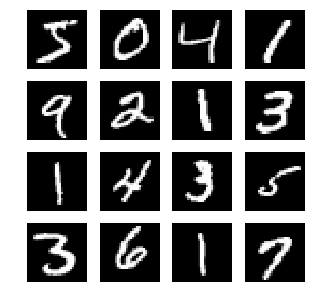

In [7]:
#loading the dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data() # load the dataset
x_train = tf.cast(x_train, tf.float32)/255. #normalize the dataset
x_train = x_train[..., tf.newaxis] # add the channel axis
print(x_train.shape) 
#visualize some of the dataset
fig = plt.figure(figsize=(5, 5))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x_train[i, :, :, 0] * 255.0, cmap='gray')
    plt.axis('off')

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)

In [9]:
gen_opt = tf.keras.optimizers.Adam(lr)
disc_opt = tf.keras.optimizers.Adam(lr)

In [10]:
@tf.function
def train_step(images, batch_size):
    #train the discriminator
    noise = tf.random.normal([batch_size, latent_dim])
    
    with tf.GradientTape() as tape:
        gen_images = gen(noise)
        
        real_prob = disc(images)
        generated_prob = tf.debugging.check_numerics(disc(gen_images), 'disc prob of generated images')        

        disc_loss = -tf.reduce_mean(tf.math.log(real_prob) + tf.math.log(1. - generated_prob))
         
    tf.debugging.check_numerics(tf.math.log(real_prob), 'disc loss real prob part')
    tf.debugging.check_numerics(tf.math.log(1. - generated_prob), 
                                'disc loss gen prob part {}'.format(tf.math.reduce_max(generated_prob)))
        
    grad_disc = tape.gradient(disc_loss, disc.trainable_variables)
    disc_opt.apply_gradients(zip(grad_disc, disc.trainable_variables))
    
    #train the generator
    noise = tf.random.normal([batch_size, latent_dim])
    
    with tf.GradientTape() as tape:
        gen_images = gen(noise)
        
        generated_prob = disc(gen_images)
                
        gen_loss = -tf.reduce_mean(tf.math.log(generated_prob))
        
    tf.debugging.check_numerics(tf.math.log(generated_prob), 'gen loss part')
    
    grad_gen = tape.gradient(gen_loss, gen.trainable_variables)
    gen_opt.apply_gradients(zip(grad_gen, gen.trainable_variables))
    
    disc_real_acc = tf.reduce_mean(1 - (tf.ones_like(real_prob) - tf.cast(real_prob>=0.5, tf.float32))) # accuracy of the discriminator to detect the real images
    disc_gen_acc = tf.reduce_mean(1 - (tf.ones_like(generated_prob) - tf.cast(generated_prob>=0.5, tf.float32))) #accuracy of the discriminator thinking that the generated image is real i.e.:the accuray of the generator to fool the diecriminator 
    
    return gen_loss, disc_loss, disc_real_acc, disc_gen_acc


In [11]:
def save_gen_imgs(epoch, generator, noise):    
    gen_imgs = generator(noise)
    gen_imgs = gen_imgs.numpy()
    fig = plt.figure(figsize=(5, 5))
    for i in range(gen_imgs.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(gen_imgs[i, :, :, 0]*255, cmap='gray')
        plt.axis('off')
    fig.savefig("gen_images/image_{}.png".format(str(epoch).zfill(5)))

def status_printing(status_list):
    status_epoch = str(status_list[0]).zfill(4)
    status_epoch_time = str(round(status_list[1], 2)).zfill(5)
    status_gen_loss = str(round(status_list[2], 3)).zfill(6)
    status_disc_loss = str(round(status_list[3], 3)).zfill(5)
    status_disc_real_acc = str(round(status_list[4], 2)).zfill(4)
    status_disc_gen_acc = str(round(status_list[5], 2)).zfill(4)
    print('Epoch {}, {} sec, gen_loss = {}, disc_loss = {}, disc_real_acc = {}, disc_gen_acc = {}'.format(status_epoch, 
                                                                                                          status_epoch_time, 
                                                                                                          status_gen_loss, 
                                                                                                          status_disc_loss, 
                                                                                                          status_disc_real_acc,
                                                                                                          status_disc_gen_acc))
    

In [12]:
vis_noise = tf.random.normal([16, latent_dim])

Epoch 0001, 03.37 sec, gen_loss = 05.384, disc_loss = 0.199, disc_real_acc = 0.95, disc_gen_acc = 00.0
Epoch 0002, 02.15 sec, gen_loss = 10.425, disc_loss = 0.066, disc_real_acc = 0.99, disc_gen_acc = 00.0
Epoch 0003, 01.97 sec, gen_loss = 08.024, disc_loss = 00.03, disc_real_acc = 01.0, disc_gen_acc = 00.0
Epoch 0004, 02.22 sec, gen_loss = 006.41, disc_loss = 00.04, disc_real_acc = 01.0, disc_gen_acc = 00.0
Epoch 0005, 01.35 sec, gen_loss = 06.806, disc_loss = 0.044, disc_real_acc = 0.99, disc_gen_acc = 00.0
Epoch 0006, 02.17 sec, gen_loss = 05.971, disc_loss = 0.082, disc_real_acc = 0.99, disc_gen_acc = 0.01
Epoch 0007, 01.27 sec, gen_loss = 06.155, disc_loss = 0.114, disc_real_acc = 0.98, disc_gen_acc = 0.01
Epoch 0008, 01.25 sec, gen_loss = 05.204, disc_loss = 0.147, disc_real_acc = 0.97, disc_gen_acc = 0.01
Epoch 0009, 01.27 sec, gen_loss = 05.371, disc_loss = 0.189, disc_real_acc = 0.96, disc_gen_acc = 0.01
Epoch 0010, 01.25 sec, gen_loss = 05.903, disc_loss = 0.178, disc_real_ac

Epoch 0081, 01.32 sec, gen_loss = 02.467, disc_loss = 0.665, disc_real_acc = 0.84, disc_gen_acc = 0.11
Epoch 0082, 01.28 sec, gen_loss = 002.32, disc_loss = 0.714, disc_real_acc = 0.83, disc_gen_acc = 0.12
Epoch 0083, 01.26 sec, gen_loss = 02.449, disc_loss = 0.731, disc_real_acc = 0.83, disc_gen_acc = 0.12
Epoch 0084, 01.12 sec, gen_loss = 02.763, disc_loss = 0.772, disc_real_acc = 0.82, disc_gen_acc = 0.12
Epoch 0085, 01.12 sec, gen_loss = 02.996, disc_loss = 0.652, disc_real_acc = 0.85, disc_gen_acc = 00.1
Epoch 0086, 01.12 sec, gen_loss = 02.835, disc_loss = 0.651, disc_real_acc = 0.85, disc_gen_acc = 0.11
Epoch 0087, 01.27 sec, gen_loss = 02.485, disc_loss = 0.693, disc_real_acc = 0.83, disc_gen_acc = 0.11
Epoch 0088, 01.36 sec, gen_loss = 02.377, disc_loss = 0.704, disc_real_acc = 0.83, disc_gen_acc = 0.11
Epoch 0089, 01.33 sec, gen_loss = 02.385, disc_loss = 0.744, disc_real_acc = 0.82, disc_gen_acc = 0.12
Epoch 0090, 01.16 sec, gen_loss = 02.638, disc_loss = 0.768, disc_real_ac

Epoch 0161, 01.32 sec, gen_loss = 02.178, disc_loss = 0.816, disc_real_acc = 00.8, disc_gen_acc = 0.14
Epoch 0162, 01.39 sec, gen_loss = 02.242, disc_loss = 0.832, disc_real_acc = 0.79, disc_gen_acc = 0.14
Epoch 0163, 01.43 sec, gen_loss = 02.222, disc_loss = 0.785, disc_real_acc = 0.81, disc_gen_acc = 0.14
Epoch 0164, 01.38 sec, gen_loss = 02.211, disc_loss = 0.792, disc_real_acc = 0.81, disc_gen_acc = 0.14
Epoch 0165, 01.37 sec, gen_loss = 02.163, disc_loss = 00.79, disc_real_acc = 0.81, disc_gen_acc = 0.14
Epoch 0166, 01.36 sec, gen_loss = 02.106, disc_loss = 00.81, disc_real_acc = 00.8, disc_gen_acc = 0.14
Epoch 0167, 01.34 sec, gen_loss = 02.135, disc_loss = 0.798, disc_real_acc = 00.8, disc_gen_acc = 0.14
Epoch 0168, 01.39 sec, gen_loss = 02.135, disc_loss = 0.809, disc_real_acc = 00.8, disc_gen_acc = 0.14
Epoch 0169, 01.37 sec, gen_loss = 02.094, disc_loss = 00.81, disc_real_acc = 00.8, disc_gen_acc = 0.14
Epoch 0170, 01.57 sec, gen_loss = 02.063, disc_loss = 0.819, disc_real_ac

Epoch 0241, 01.36 sec, gen_loss = 001.97, disc_loss = 0.801, disc_real_acc = 00.8, disc_gen_acc = 0.14
Epoch 0242, 01.14 sec, gen_loss = 01.974, disc_loss = 0.808, disc_real_acc = 00.8, disc_gen_acc = 0.14
Epoch 0243, 01.13 sec, gen_loss = 01.963, disc_loss = 0.807, disc_real_acc = 0.79, disc_gen_acc = 0.14
Epoch 0244, 01.12 sec, gen_loss = 02.031, disc_loss = 0.798, disc_real_acc = 00.8, disc_gen_acc = 0.14
Epoch 0245, 01.21 sec, gen_loss = 02.054, disc_loss = 0.806, disc_real_acc = 00.8, disc_gen_acc = 0.14
Epoch 0246, 01.36 sec, gen_loss = 02.042, disc_loss = 0.791, disc_real_acc = 0.81, disc_gen_acc = 0.14
Epoch 0247, 01.36 sec, gen_loss = 02.041, disc_loss = 0.797, disc_real_acc = 00.8, disc_gen_acc = 0.14
Epoch 0248, 01.34 sec, gen_loss = 02.076, disc_loss = 0.798, disc_real_acc = 00.8, disc_gen_acc = 0.14
Epoch 0249, 01.46 sec, gen_loss = 02.104, disc_loss = 0.785, disc_real_acc = 00.8, disc_gen_acc = 0.13
Epoch 0250, 01.47 sec, gen_loss = 02.072, disc_loss = 0.802, disc_real_ac

Epoch 0321, 01.46 sec, gen_loss = 02.138, disc_loss = 0.755, disc_real_acc = 0.81, disc_gen_acc = 0.12
Epoch 0322, 01.43 sec, gen_loss = 02.099, disc_loss = 00.77, disc_real_acc = 0.81, disc_gen_acc = 0.13
Epoch 0323, 01.41 sec, gen_loss = 02.084, disc_loss = 0.756, disc_real_acc = 0.81, disc_gen_acc = 0.13
Epoch 0324, 01.39 sec, gen_loss = 02.074, disc_loss = 0.769, disc_real_acc = 00.8, disc_gen_acc = 0.13
Epoch 0325, 01.35 sec, gen_loss = 02.048, disc_loss = 0.767, disc_real_acc = 00.8, disc_gen_acc = 0.13
Epoch 0326, 01.46 sec, gen_loss = 02.036, disc_loss = 0.771, disc_real_acc = 00.8, disc_gen_acc = 0.13
Epoch 0327, 01.49 sec, gen_loss = 02.035, disc_loss = 0.758, disc_real_acc = 00.8, disc_gen_acc = 0.13
Epoch 0328, 01.39 sec, gen_loss = 02.021, disc_loss = 0.758, disc_real_acc = 00.8, disc_gen_acc = 0.13
Epoch 0329, 01.37 sec, gen_loss = 02.036, disc_loss = 00.75, disc_real_acc = 0.81, disc_gen_acc = 0.12
Epoch 0330, 01.34 sec, gen_loss = 02.053, disc_loss = 0.766, disc_real_ac

Epoch 0401, 002.6 sec, gen_loss = 02.197, disc_loss = 00.72, disc_real_acc = 0.81, disc_gen_acc = 0.11
Epoch 0402, 03.04 sec, gen_loss = 02.127, disc_loss = 0.729, disc_real_acc = 0.81, disc_gen_acc = 0.12
Epoch 0403, 02.63 sec, gen_loss = 02.164, disc_loss = 0.717, disc_real_acc = 0.81, disc_gen_acc = 0.11
Epoch 0404, 01.95 sec, gen_loss = 02.099, disc_loss = 0.741, disc_real_acc = 0.81, disc_gen_acc = 0.12
Epoch 0405, 02.15 sec, gen_loss = 002.15, disc_loss = 0.716, disc_real_acc = 0.81, disc_gen_acc = 0.11
Epoch 0406, 01.68 sec, gen_loss = 02.112, disc_loss = 0.731, disc_real_acc = 0.81, disc_gen_acc = 0.12
Epoch 0407, 01.55 sec, gen_loss = 02.131, disc_loss = 0.729, disc_real_acc = 0.81, disc_gen_acc = 0.12
Epoch 0408, 01.72 sec, gen_loss = 02.152, disc_loss = 0.722, disc_real_acc = 0.81, disc_gen_acc = 0.12
Epoch 0409, 02.08 sec, gen_loss = 02.163, disc_loss = 0.737, disc_real_acc = 0.81, disc_gen_acc = 0.12
Epoch 0410, 01.62 sec, gen_loss = 02.162, disc_loss = 0.728, disc_real_ac

Epoch 0481, 01.33 sec, gen_loss = 02.169, disc_loss = 0.699, disc_real_acc = 0.81, disc_gen_acc = 0.11
Epoch 0482, 01.34 sec, gen_loss = 02.137, disc_loss = 0.705, disc_real_acc = 0.81, disc_gen_acc = 0.11
Epoch 0483, 01.29 sec, gen_loss = 02.131, disc_loss = 00.71, disc_real_acc = 0.81, disc_gen_acc = 0.11
Epoch 0484, 01.41 sec, gen_loss = 02.123, disc_loss = 0.698, disc_real_acc = 0.81, disc_gen_acc = 00.1
Epoch 0485, 01.39 sec, gen_loss = 02.127, disc_loss = 0.701, disc_real_acc = 0.81, disc_gen_acc = 0.11
Epoch 0486, 01.43 sec, gen_loss = 02.146, disc_loss = 0.699, disc_real_acc = 0.81, disc_gen_acc = 0.11
Epoch 0487, 01.67 sec, gen_loss = 02.161, disc_loss = 0.695, disc_real_acc = 0.81, disc_gen_acc = 0.11
Epoch 0488, 01.68 sec, gen_loss = 02.181, disc_loss = 0.697, disc_real_acc = 0.81, disc_gen_acc = 0.11
Epoch 0489, 01.51 sec, gen_loss = 02.179, disc_loss = 000.7, disc_real_acc = 0.81, disc_gen_acc = 0.11
Epoch 0490, 001.5 sec, gen_loss = 02.174, disc_loss = 0.706, disc_real_ac

Epoch 0561, 001.7 sec, gen_loss = 02.234, disc_loss = 0.668, disc_real_acc = 0.82, disc_gen_acc = 00.1
Epoch 0562, 01.63 sec, gen_loss = 02.215, disc_loss = 0.676, disc_real_acc = 0.82, disc_gen_acc = 00.1
Epoch 0563, 01.47 sec, gen_loss = 02.242, disc_loss = 0.667, disc_real_acc = 0.82, disc_gen_acc = 00.1
Epoch 0564, 01.49 sec, gen_loss = 02.208, disc_loss = 0.672, disc_real_acc = 0.82, disc_gen_acc = 00.1
Epoch 0565, 01.47 sec, gen_loss = 02.227, disc_loss = 0.669, disc_real_acc = 0.82, disc_gen_acc = 00.1
Epoch 0566, 01.39 sec, gen_loss = 02.251, disc_loss = 0.669, disc_real_acc = 0.82, disc_gen_acc = 00.1
Epoch 0567, 01.44 sec, gen_loss = 02.258, disc_loss = 0.681, disc_real_acc = 0.81, disc_gen_acc = 00.1
Epoch 0568, 01.33 sec, gen_loss = 02.254, disc_loss = 0.672, disc_real_acc = 0.82, disc_gen_acc = 00.1
Epoch 0569, 01.34 sec, gen_loss = 02.214, disc_loss = 0.667, disc_real_acc = 0.82, disc_gen_acc = 00.1
Epoch 0570, 01.35 sec, gen_loss = 02.203, disc_loss = 0.676, disc_real_ac

Epoch 0641, 01.47 sec, gen_loss = 02.255, disc_loss = 0.658, disc_real_acc = 0.82, disc_gen_acc = 0.09
Epoch 0642, 01.57 sec, gen_loss = 02.218, disc_loss = 0.666, disc_real_acc = 0.82, disc_gen_acc = 00.1
Epoch 0643, 02.17 sec, gen_loss = 02.222, disc_loss = 00.66, disc_real_acc = 0.82, disc_gen_acc = 00.1
Epoch 0644, 02.05 sec, gen_loss = 002.22, disc_loss = 0.658, disc_real_acc = 0.82, disc_gen_acc = 0.09
Epoch 0645, 01.69 sec, gen_loss = 002.22, disc_loss = 0.665, disc_real_acc = 0.82, disc_gen_acc = 00.1
Epoch 0646, 01.67 sec, gen_loss = 002.23, disc_loss = 00.65, disc_real_acc = 0.82, disc_gen_acc = 0.09
Epoch 0647, 01.51 sec, gen_loss = 02.234, disc_loss = 0.657, disc_real_acc = 0.82, disc_gen_acc = 00.1
Epoch 0648, 01.51 sec, gen_loss = 02.237, disc_loss = 0.662, disc_real_acc = 0.82, disc_gen_acc = 0.09
Epoch 0649, 01.51 sec, gen_loss = 02.255, disc_loss = 0.656, disc_real_acc = 0.82, disc_gen_acc = 0.09
Epoch 0650, 01.67 sec, gen_loss = 02.238, disc_loss = 0.654, disc_real_ac

Epoch 0721, 01.73 sec, gen_loss = 02.294, disc_loss = 0.638, disc_real_acc = 0.82, disc_gen_acc = 0.09
Epoch 0722, 01.74 sec, gen_loss = 02.301, disc_loss = 0.636, disc_real_acc = 0.82, disc_gen_acc = 0.09
Epoch 0723, 01.69 sec, gen_loss = 02.299, disc_loss = 0.637, disc_real_acc = 0.82, disc_gen_acc = 0.09
Epoch 0724, 01.64 sec, gen_loss = 02.281, disc_loss = 0.648, disc_real_acc = 0.82, disc_gen_acc = 0.09
Epoch 0725, 01.42 sec, gen_loss = 02.276, disc_loss = 0.634, disc_real_acc = 0.82, disc_gen_acc = 0.09
Epoch 0726, 01.36 sec, gen_loss = 02.264, disc_loss = 0.648, disc_real_acc = 0.82, disc_gen_acc = 0.09
Epoch 0727, 01.38 sec, gen_loss = 002.29, disc_loss = 0.638, disc_real_acc = 0.82, disc_gen_acc = 0.09
Epoch 0728, 01.67 sec, gen_loss = 02.274, disc_loss = 0.644, disc_real_acc = 0.82, disc_gen_acc = 0.09
Epoch 0729, 001.8 sec, gen_loss = 02.266, disc_loss = 0.642, disc_real_acc = 0.82, disc_gen_acc = 0.09
Epoch 0730, 02.04 sec, gen_loss = 002.25, disc_loss = 0.644, disc_real_ac

Epoch 0801, 01.68 sec, gen_loss = 02.312, disc_loss = 0.631, disc_real_acc = 0.82, disc_gen_acc = 0.09
Epoch 0802, 01.66 sec, gen_loss = 02.304, disc_loss = 0.627, disc_real_acc = 0.82, disc_gen_acc = 0.09
Epoch 0803, 01.48 sec, gen_loss = 02.301, disc_loss = 0.628, disc_real_acc = 0.82, disc_gen_acc = 0.09
Epoch 0804, 001.5 sec, gen_loss = 002.29, disc_loss = 0.636, disc_real_acc = 0.82, disc_gen_acc = 0.09
Epoch 0805, 01.45 sec, gen_loss = 02.296, disc_loss = 0.628, disc_real_acc = 0.83, disc_gen_acc = 0.09
Epoch 0806, 01.41 sec, gen_loss = 02.311, disc_loss = 0.632, disc_real_acc = 0.82, disc_gen_acc = 0.09
Epoch 0807, 001.4 sec, gen_loss = 02.294, disc_loss = 0.627, disc_real_acc = 0.82, disc_gen_acc = 0.09
Epoch 0808, 001.4 sec, gen_loss = 002.32, disc_loss = 0.623, disc_real_acc = 0.83, disc_gen_acc = 0.09
Epoch 0809, 01.48 sec, gen_loss = 02.322, disc_loss = 0.628, disc_real_acc = 0.82, disc_gen_acc = 0.09
Epoch 0810, 01.46 sec, gen_loss = 02.304, disc_loss = 0.628, disc_real_ac

Epoch 0881, 01.73 sec, gen_loss = 02.334, disc_loss = 0.623, disc_real_acc = 0.83, disc_gen_acc = 0.09
Epoch 0882, 01.73 sec, gen_loss = 02.332, disc_loss = 00.63, disc_real_acc = 0.82, disc_gen_acc = 0.09
Epoch 0883, 01.53 sec, gen_loss = 002.31, disc_loss = 0.622, disc_real_acc = 0.82, disc_gen_acc = 0.09
Epoch 0884, 01.51 sec, gen_loss = 02.298, disc_loss = 0.626, disc_real_acc = 0.82, disc_gen_acc = 0.09
Epoch 0885, 01.44 sec, gen_loss = 02.308, disc_loss = 0.622, disc_real_acc = 0.83, disc_gen_acc = 0.09
Epoch 0886, 01.38 sec, gen_loss = 002.32, disc_loss = 0.626, disc_real_acc = 0.82, disc_gen_acc = 0.09
Epoch 0887, 01.43 sec, gen_loss = 02.301, disc_loss = 0.621, disc_real_acc = 0.82, disc_gen_acc = 0.09
Epoch 0888, 01.48 sec, gen_loss = 02.313, disc_loss = 0.627, disc_real_acc = 0.82, disc_gen_acc = 0.09
Epoch 0889, 01.45 sec, gen_loss = 02.305, disc_loss = 0.627, disc_real_acc = 0.82, disc_gen_acc = 0.08
Epoch 0890, 01.45 sec, gen_loss = 02.299, disc_loss = 0.623, disc_real_ac

Epoch 0961, 01.51 sec, gen_loss = 002.33, disc_loss = 0.621, disc_real_acc = 0.82, disc_gen_acc = 0.09
Epoch 0962, 01.86 sec, gen_loss = 02.321, disc_loss = 0.622, disc_real_acc = 0.82, disc_gen_acc = 0.09
Epoch 0963, 01.74 sec, gen_loss = 002.31, disc_loss = 0.618, disc_real_acc = 0.82, disc_gen_acc = 0.09
Epoch 0964, 01.82 sec, gen_loss = 02.315, disc_loss = 0.631, disc_real_acc = 0.82, disc_gen_acc = 0.09
Epoch 0965, 01.81 sec, gen_loss = 02.299, disc_loss = 0.626, disc_real_acc = 0.82, disc_gen_acc = 0.09
Epoch 0966, 01.75 sec, gen_loss = 02.273, disc_loss = 0.626, disc_real_acc = 0.82, disc_gen_acc = 0.09
Epoch 0967, 01.45 sec, gen_loss = 02.257, disc_loss = 00.63, disc_real_acc = 0.82, disc_gen_acc = 0.09
Epoch 0968, 01.37 sec, gen_loss = 02.284, disc_loss = 0.628, disc_real_acc = 0.82, disc_gen_acc = 0.09
Epoch 0969, 01.47 sec, gen_loss = 002.27, disc_loss = 0.631, disc_real_acc = 0.82, disc_gen_acc = 0.09
Epoch 0970, 01.45 sec, gen_loss = 02.297, disc_loss = 0.626, disc_real_ac

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Total training time: 0.44775465177165136 hrs


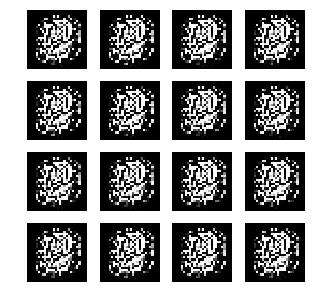

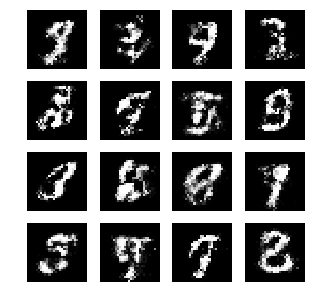

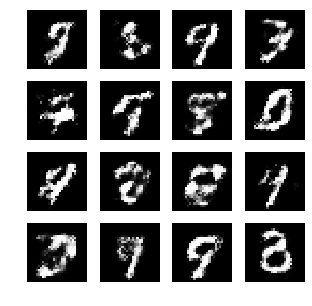

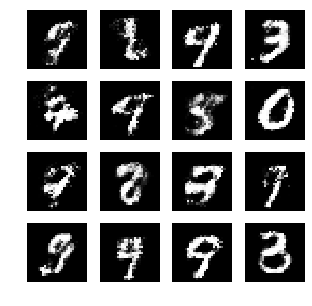

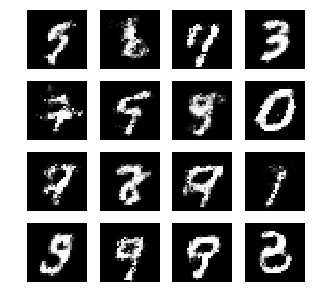

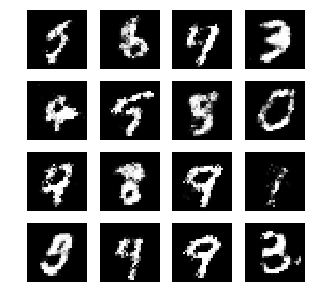

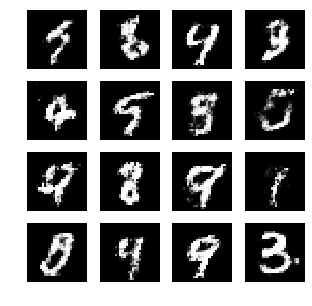

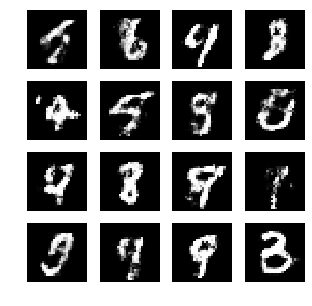

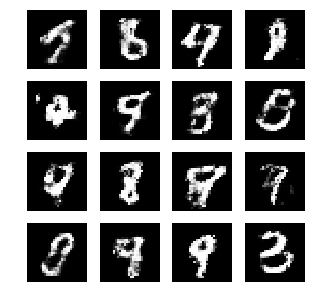

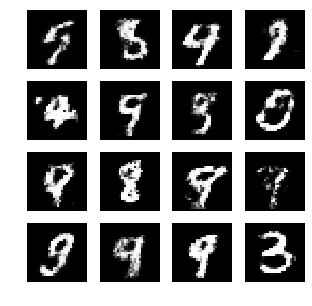

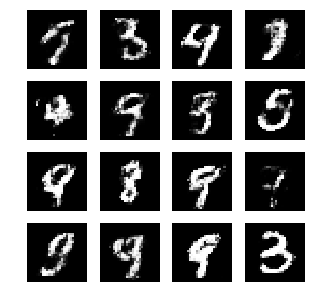

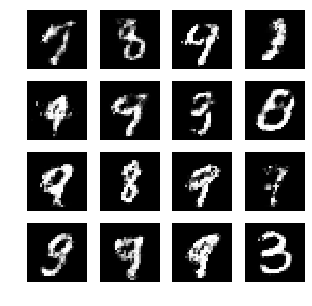

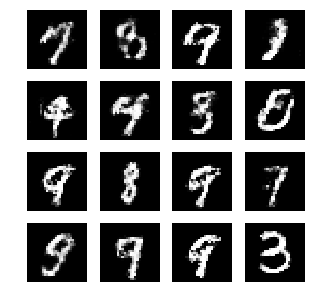

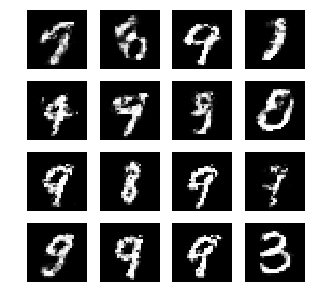

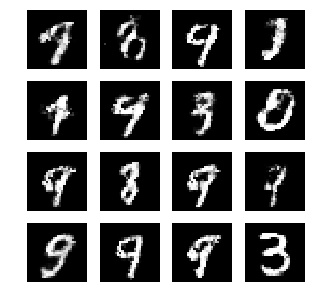

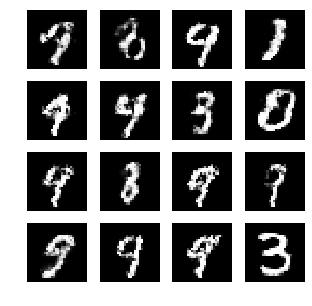

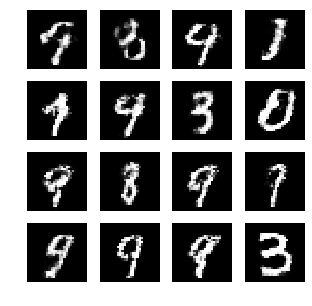

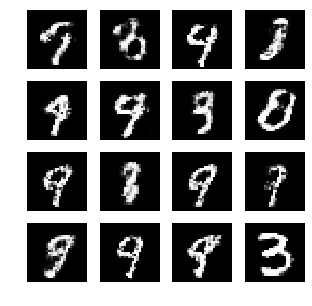

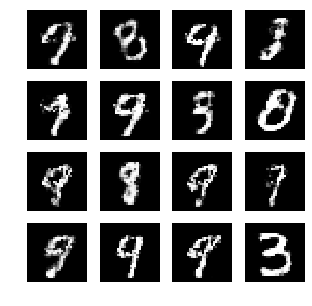

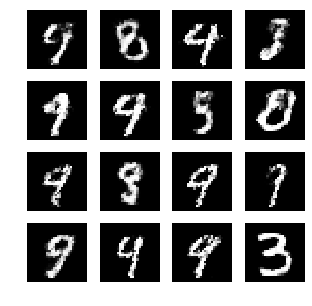

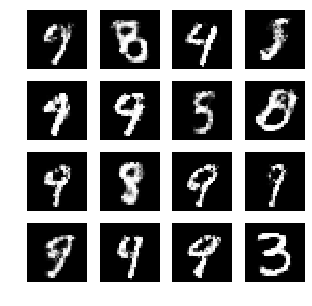

In [13]:
gen_loss_list = []
disc_loss_list = []
training_start_time = time.time()
for epoch in range(epochs):
    start = time.time()
    total_gen_loss = 0
    total_disc_loss = 0
    total_disc_real_acc = 0
    total_disc_gen_acc = 0
    count = 0

    for images,labels in train_ds:
        batch_s = images.shape[0]
        gen_loss, disc_loss, disc_real_acc, disc_gen_acc = train_step(images, batch_s)

        total_gen_loss += gen_loss
        total_disc_loss += disc_loss
        total_disc_real_acc += disc_real_acc
        total_disc_gen_acc += disc_gen_acc
        count += 1
    #calculate avergae metrics over the epoch
    avg_gen_loss = total_gen_loss.numpy()/count
    avg_disc_loss = total_disc_loss.numpy()/count
    avg_disc_real_acc = total_disc_real_acc.numpy()/count
    avg_disc_gen_acc = total_disc_gen_acc.numpy()/count
    
    gen_loss_list.append(avg_gen_loss)
    disc_loss_list.append(avg_disc_loss)
    
    #printing training status
    status_list = [epoch + 1, time.time() - start, avg_gen_loss, avg_disc_loss, 
                   avg_disc_real_acc, avg_disc_gen_acc]
    status_printing(status_list)
    
                                                                                                   
    if epoch % save_interval == 0:
        save_gen_imgs(epoch, gen, vis_noise)
save_gen_imgs(epoch, gen, vis_noise)        
training_time_in_hrs = (time.time() - training_start_time) / (60*60)
print('Total training time: {} hrs'.format(training_time_in_hrs))

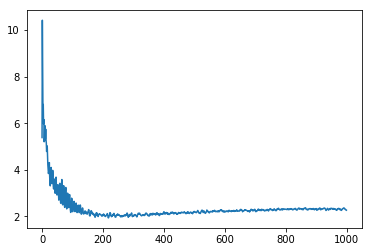

In [14]:
plt.plot(gen_loss_list)
plt.show()

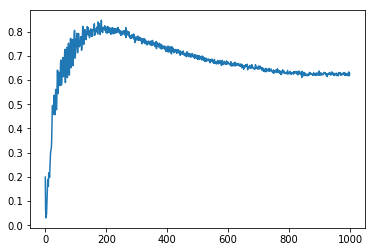

In [15]:
plt.plot(disc_loss_list)
plt.show()